In [1]:
import SimpleITK as sitk
import numpy as np
import os
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import glob
import matplotlib.pyplot as plt
import random
import torchvision.transforms as T

In [2]:
debug_print = False
debug_plot = True


### 讀取資料Luna16、製作Mask、正規化、肺實質切割

In [3]:
#/*將HU值固定在[-1024, 3071]*/
def sanitize_hu(ct):#numpy
    ct_n = ct.astype(np.float32, copy=True) #//deepcopy
    ct_n  = np.clip(ct_n , -1024.0, 3071.0) #//取上下限
    return ct_n 
def sanitize_hu_torch(ct: torch.Tensor): #torch
    ct_n = ct.float()
    ct_n = torch.clamp(ct_n, -1024.0, 3071.0) # //取上下限
    return ct_n
def window_to_uint8(ct_n, wl=-600, ww=1500):
    low, high = wl - ww/2, wl + ww/2 
    ct_n2 = np.clip(ct_n, low, high) 
    ct_n2 = ((ct_n2 - low) / ww * 255).astype('uint8') #//正規化至 [0~255]
    return ct_n2
def window_to_uint8_torch(ct_n: torch.Tensor, wl: float = -600.0, ww: float = 1500.0) -> torch.Tensor:
    low = wl - ww / 2.0 
    high = wl + ww / 2.0
    ct_n2 = torch.clamp(ct_n, low, high)
    ct_n2 = (ct_n2 - low) / ww * 255.0
    ct_n2 = ct_n2.to(torch.uint8) 
    return ct_n2

In [4]:
# --- 1. Mask 生成函式 (使用 SimpleITK 處理) ---
def get_mask(itk_image: sitk.Image, annotations: pd.DataFrame, series_uid: str) -> np.ndarray:
    """
    根據 SimpleITK 影像的元資料和標註資訊，生成對應的 Mask。
    
    :param itk_image: SimpleITK 讀取的 CT 影像物件。
    :param annotations: 包含所有 LUNA16 標註的 DataFrame。
    :param series_uid: 當前 CT 掃描的唯一 ID。
    :return: 與 image 具有相同 shape (Z, 512, 512) 的 NumPy mask 陣列。
    """
    # 建立一個全黑 (0) 的 Mask 影像，與原圖大小相同
    mask_image = sitk.Image(itk_image.GetSize(), sitk.sitkUInt8)
    mask_image.CopyInformation(itk_image) # 確保 Mask 與原圖有相同的 Origin, Spacing, Direction
    
    # 過濾出當前 series_uid 的所有標註
    series_annotations = annotations[annotations['seriesuid'] == series_uid]

    if series_annotations.empty:
        # 如果沒有標註，返回一個全黑的 NumPy 陣列
        return sitk.GetArrayFromImage(mask_image)
    
    # 遍歷所有結節標註
    for _, row in series_annotations.iterrows():
        # 標註資訊 (LUNA16 提供的世界座標)
        coordX, coordY, coordZ = row['coordX'], row['coordY'], row['coordZ']
        diameter_mm = row['diameter_mm']
        
        # 1. 轉換世界座標到體素 (Voxel) 座標
        # SimpleITK 的座標順序是 (X, Y, Z)，與 LUNA16 CSV 中的 (coordX, coordY, coordZ) 一致
        physical_point = (coordX, coordY, coordZ)
        try:
            # 獲取標註中心點的體素索引 (Voxel Index)
            voxel_index = itk_image.TransformPhysicalPointToIndex(physical_point)
        except Exception as e:
            print(f"無法將世界座標 {physical_point} 轉換為體素座標，可能超出影像範圍。錯誤: {e}")
            continue

        # 2. 建立標註的球體
        radius_mm = diameter_mm / 2.0

        spacing = itk_image.GetSpacing() # (SpacingX, SpacingY, SpacingZ)
        
        # 在 Mask 影像中標記中心點
        if all(0 <= idx < size for idx, size in zip(voxel_index, itk_image.GetSize())):
             # 設置中心點為 1
             mask_image[voxel_index] = 1 
        
        # 設置膨脹/侵蝕的半徑 (以像素為單位)
        radius_pixels = int(np.round(diameter_mm / np.mean(spacing) / 2.0))
        radius_pixels = max(1, radius_pixels) # 最小半徑為 1

        # *** 關鍵修正步驟 ***
        # SimpleITK 期望的半徑是 3D 向量 (X, Y, Z)，即使是球體，也需要指定三個維度的半徑
        # 由於我們希望是球體，所以 X, Y, Z 的半徑都設為 radius_pixels
        kernel_radius_3d = [radius_pixels] * 3 

        # 進行膨脹操作 (Dilate)，必須傳入 3D 半徑向量
        dilated_mask = sitk.BinaryDilate(
            mask_image, 
            kernel_radius_3d, 
            sitk.sitkBall 
        )
        mask_image = dilated_mask # 更新 Mask 影像

    # 將最終的 SimpleITK Mask 轉換為 NumPy 陣列 (Z, Y, X)
    mask_array = sitk.GetArrayFromImage(mask_image)
    return mask_array.astype(np.float32)

In [5]:
from skimage import measure
from scipy import ndimage as ndi
from skimage.filters import roberts
from skimage.measure import label,regionprops
from skimage.segmentation import clear_border
from skimage.morphology import  convex_hull_image
from skimage.morphology import disk, binary_closing
#/*ct_n2為正規化好shape = (Z, Y, X)*/
def lung_segmentation(ct_org):
    im = ct_org.copy()  #//單張單張做 -> 可用Parallel Processing加速

    #//Step1 : 二值化
    binary_thr = im <  175   #前面有正規化至0~255 
    
    #//Step2 : 清理邊界
    cleared = clear_border(binary_thr) 
    
    #//Step3 : 標記
    label_image = label(cleared)  
    
    #//Step4 : 找出最大的兩個label -> 即肺部
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    labels = []
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-2]:
                for coordinates in region.coords:
                    label_image[coordinates[0], coordinates[1]] = 0
            else:
                coordinates = region.coords[0]
                labels.append(label_image[coordinates[0], coordinates[1]])
    else:
        labels = [1, 2]
        
    #//Step5 : 填充兩肺空洞
    r = label_image == labels[0]
    l = label_image == labels[1]
    r_edges = roberts(r)
    l_edges = roberts(l)
    r = ndi.binary_fill_holes(r_edges)
    l = ndi.binary_fill_holes(l_edges)
    
    #//Step6 : 平滑包覆
    r = convex_hull_image(r)
    l = convex_hull_image(l)
    
    #//Step7 : 閉合兩肺
    sum_of_lr = r + l
    binary = sum_of_lr > 0
    selem = disk(10) #radius =10
    binary_c = binary_closing(binary, selem)
    
    #//Step8 : im即為原圖ROI區域
    noise = binary_c == 0 #//binary_c為0的地方，noise為True->找出背景雜訊
    im[noise] = 0 #//把不要的地方設成0 -> 劃出我們要得ROI (肺實質)
    
    
    #//Cache
    #case_img[z_idx]=ct_org  #原圖
    #lungs_img[z_idx]=im     #原圖的ROI
           #原圖    #原圖的ROI
    return ct_org , im 

In [6]:

# --- 1. 定義 LUNA16 資料集類別 ---
class Luna16MaskDataset(Dataset):
    def __init__(self, data_dir="data/subset0", annotations_file='annotations.csv'):
        self.data_dir = data_dir
        
        # 使用 glob 找到所有 .mhd 檔案
        mhd_paths = glob.glob(os.path.join(data_dir, '*.mhd'))
        self.full_paths = mhd_paths

        if not self.full_paths:
            print(f"警告：在路徑 '{data_dir}' 中找不到任何 .mhd 檔案。")

        # 讀取 LUNA16 標註 CSV 檔案
        try:
            self.annotations = pd.read_csv(annotations_file)
        except FileNotFoundError:
            print(f"錯誤：找不到標註檔案 '{annotations_file}'。Mask 將返回全零。")
            self.annotations = pd.DataFrame({'seriesuid': [], 'coordX': [], 'coordY': [], 'coordZ': [], 'diameter_mm': []})
        except Exception as e:
            print(f"讀取標註檔案時發生錯誤：{e}。Mask 將返回全零。")
            self.annotations = pd.DataFrame({'seriesuid': [], 'coordX': [], 'coordY': [], 'coordZ': [], 'diameter_mm': []})

    def __len__(self):
        return len(self.full_paths)

    def __getitem__(self, idx):
        file_path = self.full_paths[idx]
        
        # 從檔案名稱中提取 seriesuid
        file_name = os.path.basename(file_path)
        print(f'✅️ file_name = {file_name}')
        series_uid = os.path.splitext(file_name)[0]
        print(f"✅️ Processing series_uid: {series_uid}")
        
        # 1. 讀取 CT 影像
        itk_image = sitk.ReadImage(file_path)
        
        # 轉換為 PyTorch Tensor (Z, Y, X)
        ct = sitk.GetArrayFromImage(itk_image)
        ct_n = sanitize_hu(ct)
        numpy_array = window_to_uint8(ct_n) 

        # 2. 生成 Mask
        mask_array = get_mask(itk_image, self.annotations, series_uid)

        # 3. 肺切割 ---
        z_len = numpy_array.shape[0]
        H, W = numpy_array.shape[1], numpy_array.shape[2]
        lung_images = np.zeros((z_len, H, W), dtype=numpy_array.dtype) # 使用 images 相同的类型

        for z_idx in range(z_len):
            #提取切片
            slice_n = numpy_array[z_idx]
            _, seg_slice = lung_segmentation(slice_n)
            #存
            lung_images[z_idx] = seg_slice 

        # 檢查輸出形狀
        assert lung_images.shape == numpy_array.shape, "Segmented images shape mismatch!"
        assert numpy_array.shape == mask_array.shape, "Image and Mask shape mismatch!"
        
        #轉成pytorch訓練的tensor
        image_tensor = torch.from_numpy(lung_images.astype(np.float32))
        mask_tensor = torch.from_numpy(mask_array.astype(np.float32))

        return {
            'image': image_tensor,          # Shape: (Z, 512, 512), dtype=torch.float32
            'mask': mask_tensor,            # Shape: (Z, 512, 512), dtype=torch.float32 (0.0 或 1.0)
            'series_uid': series_uid,
        }



In [7]:
LUNA16_DATA_DIR = r"D:\Daniel\LDCT\luna16-yolo\dataset_luna\subset0"
LUNA16_ANNOTATIONS_CSV = r"D:\Daniel\LDCT\luna16-yolo\CSVFILES\annotations.csv" 

In [8]:
# 建立 Dataset 實例
luna_dataset = Luna16MaskDataset(
    data_dir=LUNA16_DATA_DIR,
    annotations_file=LUNA16_ANNOTATIONS_CSV
)

print(f"找到 {len(luna_dataset)} 個 CT 掃描檔案。")

找到 4 個 CT 掃描檔案。


✅️ file_name = 1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860.mhd
✅️ Processing series_uid: 1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860


C:\Users\ygz08\AppData\Local\Temp\ipykernel_548\1117151877.py:46: UserWarning: Input image is entirely zero, no valid convex hull. Returning empty image
  l = convex_hull_image(l)


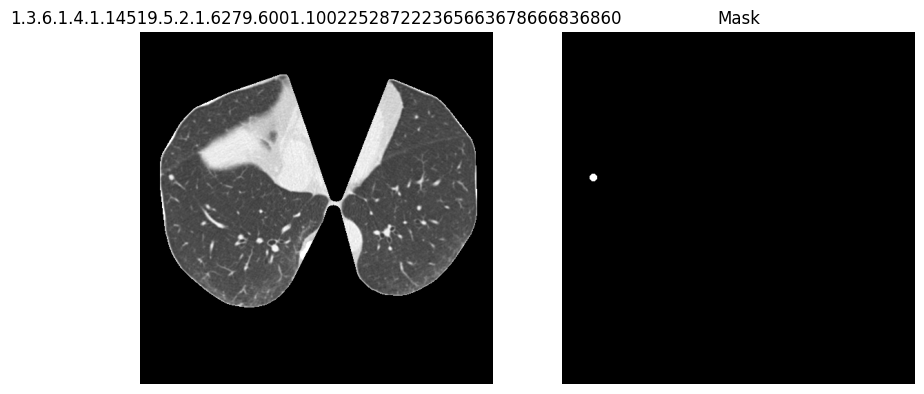

空間形狀是否符合 (Z, 512, 512): True

資料讀取、Mask 生成與轉換範例完成。


In [9]:
# 建立 DataLoader (batch_size=1 避免不同 Z 維度導致的錯誤)
luna_dataloader = DataLoader(luna_dataset, batch_size=1, shuffle=False)

# 迭代 DataLoader 進行檢查
for i, data in enumerate(luna_dataloader):
    image = data['image'][0]  
    mask = data['mask'][0]                     #mask
    series_uid = data['series_uid'][0]         #uid
    
    if debug_print : 
        print(f"--- 處理第 {i+1} 個檔案 ---")
        print(f"Series UID: {series_uid}")
        print(f"Image Tensor 形狀: {image.shape}")
        print(f"Mask Tensor 形狀: {mask.shape}")
        print(f"Mask 內部包含的標註體素數量 (應為 > 0): {torch.sum(mask).item()}")
    if debug_plot :
        # 顯示中間切片
        mid_slice =  78
        #print(image.shape[0])
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title(f"{series_uid}")
        plt.imshow(image[mid_slice, :, :], cmap='gray')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title("Mask")
        plt.imshow(mask[mid_slice, :, :], cmap='gray')
        plt.axis('off')
        
        plt.show()
    
    # 檢查形狀是否符合 (Z, 512, 512)
    is_correct_shape = (image.dim() == 3) and (image.shape[1] == 512) and (image.shape[2] == 512)
    print(f"空間形狀是否符合 (Z, 512, 512): {is_correct_shape}")
    
    if i >= 0: 
        break

print("\n資料讀取、Mask 生成與轉換範例完成。")

### 製作資料集 (3, 64, 64)

In [10]:
import torch
import numpy as np
import random
import torchvision.transforms.functional as F_T
import torch.nn.functional as F

# 設定參數
PATCH_SIZE = 64
Z_DEPTH = 3 
OUTPUT_MASK_DEPTH = 1 # 只預測中間切片 (Z=1) 的 Mask

# -----------------------------------------------------------
# 1. Patch 提取與平衡採樣主函式 (Segmentation專用)
# -----------------------------------------------------------
def extract_balanced_segmentation_patches(image: torch.Tensor, mask: torch.Tensor, max_patches_per_scan: int = 40) -> tuple:
    """
    從單個 CT 掃描中提取平衡的正負樣本 Patch (3, 64, 64) 及其對應的 Mask (1, 64, 64)。
    
    :param image: 單個 CT 掃描影像 Tensor (已分割肺部, 0-255)，shape (Z, 512, 512)。
    :param mask: 單個 Mask Tensor (0/1)，shape (Z, 512, 512)。
    :param max_patches_per_scan: 每個掃描最多提取的 Patch 總數 (N_pos + N_neg)。
    :return: 包含平衡 Patch 和對應 Mask 的元組 (patches, masks)。
             patches shape: (N, 3, 64, 64); masks shape: (N, 1, 64, 64)
    """
    Z, H, W = image.shape
    
    # 查找結節中心點 (用於正樣本採樣)
    positive_indices = (mask > 0).nonzero(as_tuple=False) 

    extracted_patches = []
    extracted_masks = []
    
    # ---------------------------------------------------
    # I. 正樣本採樣 (Positive Patch Sampling)
    # ---------------------------------------------------
    # 目標：正樣本數量為 max_patches_per_scan // 2
    num_positive_target = max_patches_per_scan // 2
    
    # 遍歷潛在的正樣本體素中心
    if len(positive_indices) > 0:
        # 隨機選擇一部分中心點作為初始採樣點
        sample_indices = random.sample(positive_indices.tolist(), min(len(positive_indices), num_positive_target * 2))
        
        for z_c, y_c, x_c in sample_indices:
            if z_c < 1 or z_c >= Z - 1: # 確保 Z-1 和 Z+1 存在
                continue

            # 隨機偏移中心點
            offset_y = random.randint(-PATCH_SIZE // 4, PATCH_SIZE // 4)
            offset_x = random.randint(-PATCH_SIZE // 4, PATCH_SIZE // 4)
            y_start = y_c - PATCH_SIZE // 2 + offset_y
            x_start = x_c - PATCH_SIZE // 2 + offset_x

            # 邊界檢查與裁剪
            y_start = np.clip(y_start, 0, H - PATCH_SIZE).item()
            x_start = np.clip(x_start, 0, W - PATCH_SIZE).item()
            
            # 裁剪 Image Patch (3, 64, 64)
            patch_image = image[z_c - 1 : z_c + 2, 
                                y_start : y_start + PATCH_SIZE, 
                                x_start : x_start + PATCH_SIZE].float()
            
            # 裁剪 Mask Patch (只取中間切片: 1, 64, 64)
            # unsqueeze(0) 將 (64, 64) 變為 (1, 64, 64)
            patch_mask = mask[z_c, y_start : y_start + PATCH_SIZE, 
                             x_start : x_start + PATCH_SIZE].unsqueeze(0).float()
            
            # 確保該 Patch 確實包含結節體素 (防止邊界誤採樣)
            if torch.sum(patch_mask) > 0:
                 extracted_patches.append(patch_image)
                 extracted_masks.append(patch_mask)
                 if len(extracted_patches) >= num_positive_target:
                    break
    
    # 確保我們有原始正樣本可供增強
    original_positive_patches = extracted_patches.copy()
    original_positive_masks = extracted_masks.copy()

    # ---------------------------------------------------
    # II. 負樣本採樣 (Negative Patch Sampling)
    # ---------------------------------------------------
    num_neg_target = max_patches_per_scan - len(original_positive_patches) # 負樣本數量是總目標減去已有的正樣本
    negative_patches = []
    negative_masks = []
    
    # 嘗試採樣負樣本，直到達到所需的數量
    for _ in range(num_neg_target * 5): 
        z_c = random.randint(1, Z - 2) 
        y_start = random.randint(0, H - PATCH_SIZE)
        x_start = random.randint(0, W - PATCH_SIZE)
        
        # 裁剪 Image Patch
        patch_image = image[z_c - 1 : z_c + 2, 
                            y_start : y_start + PATCH_SIZE, 
                            x_start : x_start + PATCH_SIZE].float()
        
        # 裁剪 Mask Patch (用於檢查是否為負樣本)
        patch_mask = mask[z_c, y_start : y_start + PATCH_SIZE, 
                         x_start : x_start + PATCH_SIZE].unsqueeze(0).float()
        
        # 條件：如果 Mask 區域內沒有任何結節像素 (總和為 0)，則視為負樣本
        if torch.sum(patch_mask) == 0:
            negative_patches.append(patch_image)
            negative_masks.append(patch_mask) # 負樣本的 Mask 是一個全零的 (1, 64, 64)
            if len(negative_patches) >= num_neg_target:
                break

    # ---------------------------------------------------
    # III. 增強正樣本並與負樣本數量平衡
    # ---------------------------------------------------
    
    # 確定最終的 Patch 列表和 Mask 列表
    final_patches = negative_patches + original_positive_patches
    final_masks = negative_masks + original_positive_masks
    
    # 計算還需要多少個增強的正樣本 Patch 才能達到平衡 (這裡定義平衡為 N_pos == N_neg)
    num_pos_original = len(original_positive_patches)
    num_neg_current = len(negative_patches)

    target_pos_count = num_neg_current
    augmentation_needed = max(0, target_pos_count - num_pos_original)
    
    if num_pos_original > 0 and augmentation_needed > 0:
        for i in range(augmentation_needed):
            # 從原始正樣本中隨機選擇一個 Patch 和 Mask
            idx = random.randint(0, num_pos_original - 1)
            original_patch = original_positive_patches[idx]
            original_mask = original_positive_masks[idx]
            
            # --- 執行同步幾何增強 ---
            
            # 1. 隨機旋轉
            angle = random.uniform(-15, 15)
            # 對 Image (3, 64, 64) 和 Mask (1, 64, 64) 應用相同的旋轉
            # F_T.rotate 自動處理了 C, H, W
            augmented_patch = F_T.rotate(original_patch, angle, interpolation=F_T.InterpolationMode.BILINEAR)
            augmented_mask = F_T.rotate(original_mask, angle, interpolation=F_T.InterpolationMode.NEAREST) # Mask 必須使用 NEAREST 插值！
            
            # 2. 隨機翻轉
            if random.random() < 0.5:
                augmented_patch = F_T.hflip(augmented_patch)
                augmented_mask = F_T.hflip(augmented_mask)
            if random.random() < 0.5:
                augmented_patch = F_T.vflip(augmented_patch)
                augmented_mask = F_T.vflip(augmented_mask)
            
            # 將增強後的數據加入最終列表
            final_patches.append(augmented_patch)
            final_masks.append(augmented_mask)

    # ---------------------------------------------------
    # IV. 合併與輸出
    # ---------------------------------------------------
    if final_patches:
        patches_tensor = torch.stack(final_patches, dim=0) # Shape: (N, 3, 64, 64)
        masks_tensor = torch.stack(final_masks, dim=0)     # Shape: (N, 1, 64, 64)
        
        # 確保 Mask 仍然是二元的 (NEAREST插值後可能出現浮點數)
        masks_tensor = (masks_tensor > 0.5).float() 
        
        # 隨機打亂順序
        permutation = torch.randperm(patches_tensor.size(0))
        patches_tensor = patches_tensor[permutation]
        masks_tensor = masks_tensor[permutation]
        
        return patches_tensor, masks_tensor
    else:
        return torch.empty((0, Z_DEPTH, PATCH_SIZE, PATCH_SIZE), dtype=torch.float32), \
               torch.empty((0, OUTPUT_MASK_DEPTH, PATCH_SIZE, PATCH_SIZE), dtype=torch.float32)



In [11]:
%%time
# -----------------------------------------------------------
# 2. 修正後的 DataLoader 迴圈 (使用新的函式和輸出)
# -----------------------------------------------------------

# 這裡假設您的 __getitem__ 已經如我前述建議的修正為輸出 Tensor。
# 假設 luna_dataloader 已經定義。

all_patches_list = []
all_masks_list = [] # 變數名稱從 labels 改為 masks

for i, data in enumerate(luna_dataloader):
    image = data['image'][0]  # Lung-segmented image, (Z, 512, 512)
    mask = data['mask'][0]    # Mask, (Z, 512, 512)
    series_uid = data['series_uid'][0]
    
    print(f"提取 Segmentation Patch: {series_uid}")
    
    # ❗️ 調用修正後的 Patch 提取函式
    patches, masks = extract_balanced_segmentation_patches(
        image=image, 
        mask=mask, 
        max_patches_per_scan=40 # 每個掃描提取的 Patch 總數
    )
    
    if patches.shape[0] > 0:
        all_patches_list.append(patches)
        all_masks_list.append(masks) # 儲存 masks
        
        # 檢查輸出形狀
        assert patches.shape[1:] == (3, 64, 64), "Patch Shape Error!"
        assert masks.shape[1:] == (1, 64, 64), "Mask Shape Error!"
        
        # 統計資訊：現在我們統計的是包含結節的 Patch 數量
        num_pos_patches = (torch.sum(torch.sum(masks, dim=(1, 2, 3)) > 0.5)).item()
        print(f"  -> 成功提取 {patches.shape[0]} 個 Patch ({num_pos_patches} 個包含結節)")
    else:
        print("  -> 未提取到 Patch。")
        
# 最終合併所有 CT 掃描的 Patch
if all_patches_list:
    final_train_patches = torch.cat(all_patches_list, dim=0) # (N_total, 3, 64, 64)
    final_train_masks = torch.cat(all_masks_list, dim=0)     # (N_total, 1, 64, 64)
    
    total_patches = final_train_patches.shape[0]
    total_pos_patches = (torch.sum(torch.sum(final_train_masks, dim=(1, 2, 3)) > 0.5)).item()

    print("\n--- 最終 Segmentation Patch 數據統計 ---")
    print(f"總共提取的 Patch 數量: {total_patches}")
    print(f"其中包含結節的 Patch 數量: {total_pos_patches}")
    print(f"不含結節的 Patch 數量: {total_patches - total_pos_patches}")
    
else:
    print("\n未提取到任何 Patch 數據。請檢查資料集和標註。")

✅️ file_name = 1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860.mhd
✅️ Processing series_uid: 1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860


C:\Users\ygz08\AppData\Local\Temp\ipykernel_548\1117151877.py:46: UserWarning: Input image is entirely zero, no valid convex hull. Returning empty image
  l = convex_hull_image(l)


提取 Segmentation Patch: 1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860
  -> 成功提取 40 個 Patch (20 個包含結節)
✅️ file_name = 1.3.6.1.4.1.14519.5.2.1.6279.6001.100332161840553388986847034053.mhd
✅️ Processing series_uid: 1.3.6.1.4.1.14519.5.2.1.6279.6001.100332161840553388986847034053
提取 Segmentation Patch: 1.3.6.1.4.1.14519.5.2.1.6279.6001.100332161840553388986847034053
  -> 成功提取 40 個 Patch (0 個包含結節)
✅️ file_name = 1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793540579077826395208.mhd
✅️ Processing series_uid: 1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793540579077826395208
提取 Segmentation Patch: 1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793540579077826395208
  -> 成功提取 40 個 Patch (20 個包含結節)
✅️ file_name = 1.3.6.1.4.1.14519.5.2.1.6279.6001.100530488926682752765845212286.mhd
✅️ Processing series_uid: 1.3.6.1.4.1.14519.5.2.1.6279.6001.100530488926682752765845212286
提取 Segmentation Patch: 1.3.6.1.4.1.14519.5.2.1.6279.6001.100530488926682752765845212286
  -> 成功提取 40 個 Patch (0 個包含結

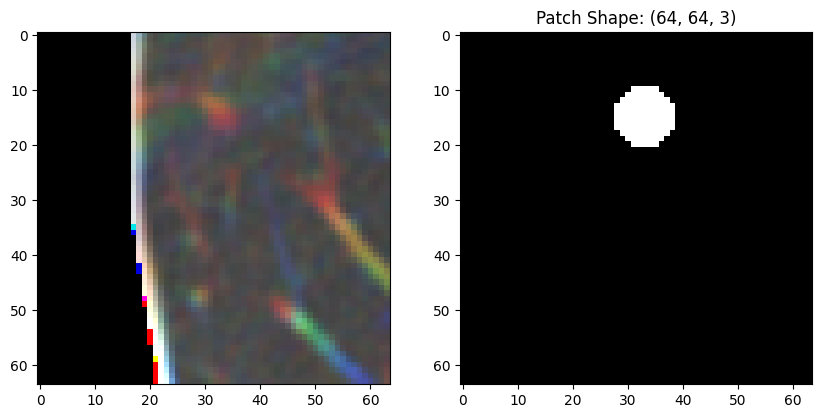

In [28]:
nslice = 23
patch_chw = final_train_patches[nslice] #(N_total,3,64,64) -> (3,64,64)
mask_chw = final_train_masks[nslice]   #(N_total,1,64,64) -> (1,64,64)
# 2. 將 PyTorch Tensor (C, H, W) 轉換為 (H, W, C) 
# 轉換維度順序：(0, 1, 2) -> (1, 2, 0)
patch_hwc = patch_chw.permute(1, 2, 0)
mask_hwc = mask_chw.permute(1, 2, 0)

patch_display = patch_hwc.cpu().numpy()
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(patch_display.astype('uint8')) 
plt.subplot(1,2,2)
plt.imshow(mask_hwc, cmap='gray')

plt.title(f"Patch Shape: {patch_display.shape}")
plt.show()

In [30]:
import torch
import os

# 設置儲存路徑和檔案名
SAVE_DIR = r"D:\Daniel\for_git\LDCT_git\TSCNN\first_stage_code\Data_processing"
FILE_NAME = "luna16_patches_balanced.pth"
SAVE_PATH = os.path.join(SAVE_DIR, FILE_NAME)

# 確保儲存目錄存在
os.makedirs(SAVE_DIR, exist_ok=True)

# final_train_patches.shape: (N_total, 3, 64, 64)
# final_train_labels.shape: (N_total, 1, 64, 64)

# 將數據包裝成字典，方便加載時區分
data_to_save = {
    'patches': final_train_patches,
    'masks': final_train_masks,
    'description': 'LUNA16 Balanced 3D Patches (3x64x64, 0-255 scaled)',
    'total_count': final_train_patches.shape[0]
}

# 執行儲存
torch.save(data_to_save, SAVE_PATH)

print(f"✅ 數據已成功儲存到: {SAVE_PATH}")

✅ 數據已成功儲存到: D:\Daniel\for_git\LDCT_git\TSCNN\first_stage_code\Data_processing\luna16_patches_balanced.pth


In [31]:
import torch

LOAD_PATH = r"D:\Daniel\for_git\LDCT_git\TSCNN\first_stage_code\Data_processing\luna16_patches_balanced.pth"

# 執行加載
loaded_data = torch.load(LOAD_PATH)

# 取出 Patch 和 Label
loaded_patches = loaded_data['patches']
loaded_labels = loaded_data['masks']

print(f"✅ 數據已成功加載。")
print(f"加載的 Patch 總數: {loaded_patches.shape[0]}")
# 您現在可以直接將 loaded_patches 和 loaded_labels 用於訓練模型！

✅ 數據已成功加載。
加載的 Patch 總數: 160


C:\Users\ygz08\AppData\Local\Temp\ipykernel_548\1589366596.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_data = torch.load(LOAD_PATH)
